# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

41188

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import time
from imblearn.over_sampling import SMOTE, ADASYN
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV




In [2]:
df = pd.read_csv('Downloads/bank-additional-full.csv', sep = ';')

In [3]:
df.shape

(41188, 21)

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [4]:
df.duplicated().sum() #Check for duplicated row. 12 found

12

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df.isna().sum() #Check for missing values.

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [7]:
df.describe().T # Shows general statistics from numeric columns.


,count,mean,std,min,25%,50%,75%,max
age,41176.0,40.023800,10.420680,17.000,32.000,38.000,47.000,98.000
duration,41176.0,258.315815,259.305321,0.000,102.000,180.000,319.000,4918.000
campaign,41176.0,2.567879,2.770318,1.000,1.000,2.000,3.000,56.000
pdays,41176.0,962.464810,186.937102,0.000,999.000,999.000,999.000,999.000
previous,41176.0,0.173013,0.494964,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41176.0,0.081922,1.570883,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41176.0,93.575720,0.578839,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41176.0,-40.502863,4.627860,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41176.0,3.621293,1.734437,0.634,1.344,4.857,4.961,5.045
nr.employed,41176.0,5167.034870,72.251364,4963.600,5099.100,5191.000,5228.100,5228.100


In [8]:
df.pdays.unique()


array([999,   6,   4,   3,   5,   1,   0,  10,   7,   8,   9,  11,   2,
        12,  13,  14,  15,  16,  21,  17,  18,  22,  25,  26,  19,  27,
        20])

In [9]:
df.previous.unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

In [10]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [11]:
df.select_dtypes(include=['float64', 'int64']).corr('pearson').style.background_gradient(axis=None)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,-0.000808,0.004622,-0.034381,0.024379,-0.000242,0.001009,0.129075,0.010852,-0.017607
duration,-0.000808,1.000000,-0.071765,-0.047556,0.020600,-0.027941,0.005303,-0.008126,-0.032861,-0.044672
campaign,0.004622,-0.071765,1.000000,0.052606,-0.079182,0.150786,0.127826,-0.013657,0.135169,0.144129
pdays,-0.034381,-0.047556,0.052606,1.000000,-0.587508,0.271063,0.078920,-0.091374,0.296946,0.372659
previous,0.024379,0.020600,-0.079182,-0.587508,1.000000,-0.420587,-0.203197,-0.050929,-0.454571,-0.501411
emp.var.rate,-0.000242,-0.027941,0.150786,0.271063,-0.420587,1.000000,0.775293,0.196257,0.972244,0.906949
cons.price.idx,0.001009,0.005303,0.127826,0.078920,-0.203197,0.775293,1.000000,0.059170,0.688180,0.521945
cons.conf.idx,0.129075,-0.008126,-0.013657,-0.091374,-0.050929,0.196257,0.059170,1.000000,0.277864,0.100679
euribor3m,0.010852,-0.032861,0.135169,0.296946,-0.454571,0.972244,0.688180,0.277864,1.000000,0.945146
nr.employed,-0.017607,-0.044672,0.144129,0.372659,-0.501411,0.906949,0.521945,0.100679,0.945146,1.000000


##### Considering the table above description

- Approximately 50% of the bank's clients are below the age of 40.
- The 'duration' column exhibits outlier values, evident from a sudden jump from 319, representing 75% of the data, to the maximum value of 4918. Additionally, the high standard deviation surpasses the median value.
- In the 'pdays' column, it is evident that at least 75% of bank customers were never contacted before.
- The 'previous' column displays a similar pattern to the 'pdays' column, indicating that clients were not contacted during the last campaign.

/var/folders/s_/v1gz0yqs2z9bbg18b7h118880000gn/T/ipykernel_2453/1900763422.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['age'], kde=True, bins=30)  # Adjust the number of bins as needed


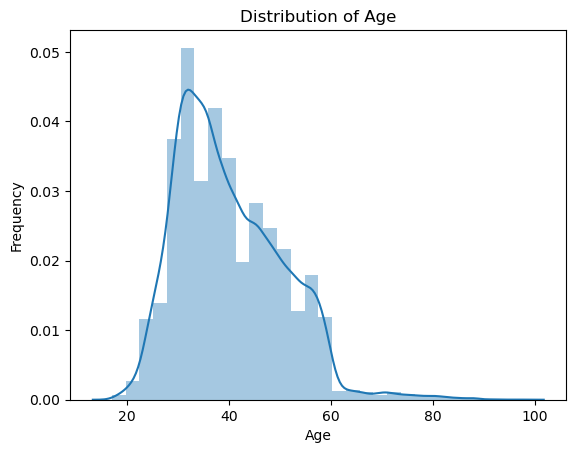

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# distribution of age column
sns.distplot(df['age'], kde=True, bins=30)  # Adjust the number of bins as needed

# Added labels and title
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')

# Show the plot
plt.show()


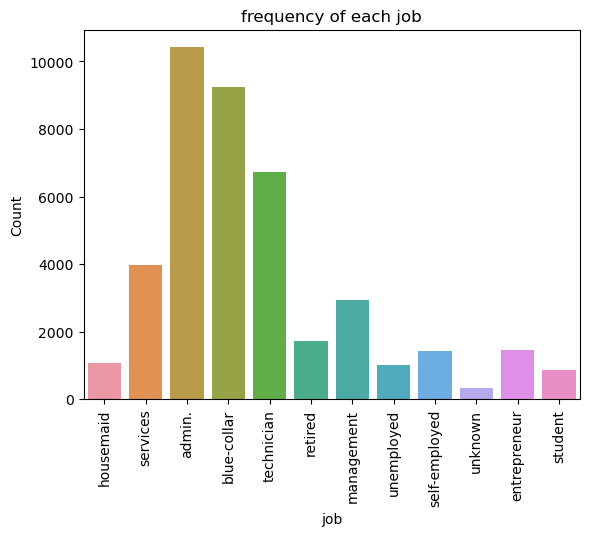

In [13]:
# Bar chart of Job column
sns.countplot(x='job', data=df)

# Rotated x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Added labels and title
plt.xlabel('job')
plt.ylabel('Count')
plt.title('frequency of each job')

# Show the plot
plt.show()

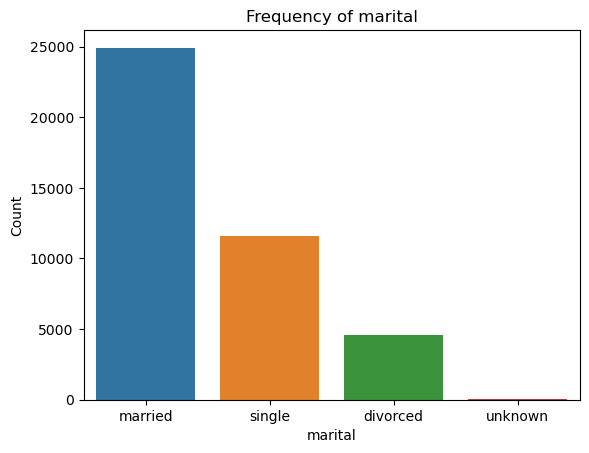

In [14]:

# Bar chart of marital status column
sns.countplot(x='marital', data=df)

# Added labels and title
plt.xlabel('marital')
plt.ylabel('Count')
plt.title('Frequency of marital')

# Show the plot
plt.show()

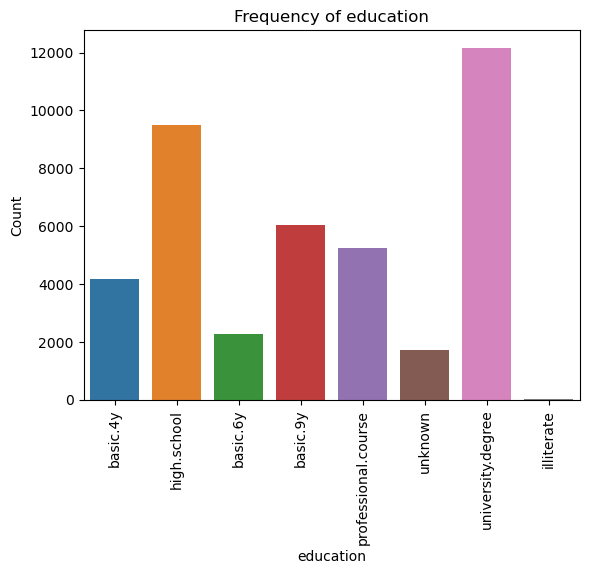

In [15]:
# Bar chart of education column
sns.countplot(x='education', data=df)
# Rotated x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Added labels and title
plt.xlabel('education')
plt.ylabel('Count')
plt.title('Frequency of education')

# Show the plot
plt.show()

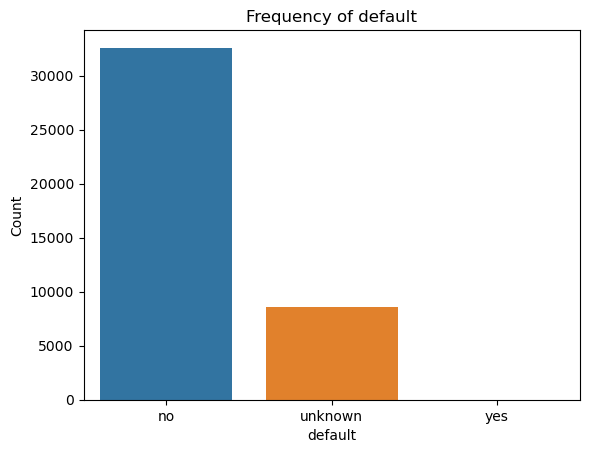

In [16]:

# Bar chart of default column
sns.countplot(x='default', data=df)

# Added labels and title
plt.xlabel('default')
plt.ylabel('Count')
plt.title('Frequency of default')

# Show the plot
plt.show()

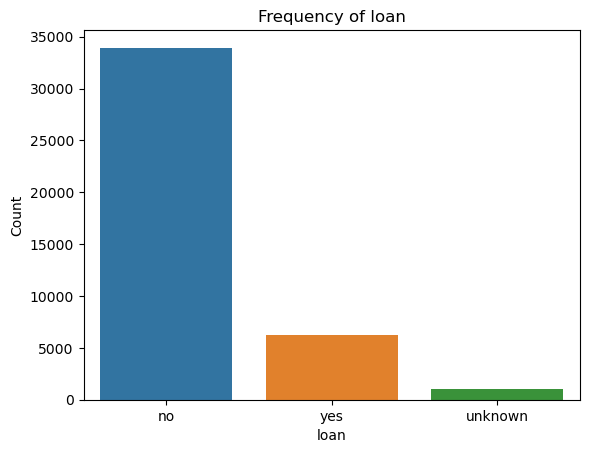

In [17]:

# Bar chart of loan column
sns.countplot(x='loan', data=df)

# Added labels and title
plt.xlabel('loan')
plt.ylabel('Count')
plt.title('Frequency of loan')

# Show the plot
plt.show()

- The 'age' column appears to exhibit a normal distribution.
- The occupations 'blue-collar,' 'management,' and 'technicians' collectively account for over 58% of the clients in our dataset.
- Approximately 60% of our clients are married.
- Half of our clients hold a secondary degree, while nearly 30% possess a tertiary degree.
- More than 95% of our data represents individuals without a history of default.
- Over 50% of our data indicates clients with housing loans.
- More than 80% of our clients do not have any form of loan.
- The 'contact' column contains numerous 'unknown' values, and the decision has been made to retain them as they are.
- The 'day' column poses challenges and will be dropped from the analysis.
- Considering the campaign strategy, it is plausible that fewer contacts were made during winter, with summer being the preferred season for campaigns.
- The 'duration' column contains several outliers, which will be addressed in subsequent steps.
- At least 75% of our data reflects instances where clients were contacted at least 3 times.
- Similarly, at least 75% of our data indicates instances where clients were not previously contacted. 



### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null 

In [19]:
df['y'].value_counts()

no     36537
yes     4639
Name: y, dtype: int64

In [20]:
correlation_matrix = df.corr()
correlation_matrix

/var/folders/s_/v1gz0yqs2z9bbg18b7h118880000gn/T/ipykernel_2453/868109210.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,-0.000808,0.004622,-0.034381,0.024379,-0.000242,0.001009,0.129075,0.010852,-0.017607
duration,-0.000808,1.000000,-0.071765,-0.047556,0.020600,-0.027941,0.005303,-0.008126,-0.032861,-0.044672
campaign,0.004622,-0.071765,1.000000,0.052606,-0.079182,0.150786,0.127826,-0.013657,0.135169,0.144129
pdays,-0.034381,-0.047556,0.052606,1.000000,-0.587508,0.271063,0.078920,-0.091374,0.296946,0.372659
previous,0.024379,0.020600,-0.079182,-0.587508,1.000000,-0.420587,-0.203197,-0.050929,-0.454571,-0.501411
emp.var.rate,-0.000242,-0.027941,0.150786,0.271063,-0.420587,1.000000,0.775293,0.196257,0.972244,0.906949
cons.price.idx,0.001009,0.005303,0.127826,0.078920,-0.203197,0.775293,1.000000,0.059170,0.688180,0.521945
cons.conf.idx,0.129075,-0.008126,-0.013657,-0.091374,-0.050929,0.196257,0.059170,1.000000,0.277864,0.100679
euribor3m,0.010852,-0.032861,0.135169,0.296946,-0.454571,0.972244,0.688180,0.277864,1.000000,0.945146
nr.employed,-0.017607,-0.044672,0.144129,0.372659,-0.501411,0.906949,0.521945,0.100679,0.945146,1.000000


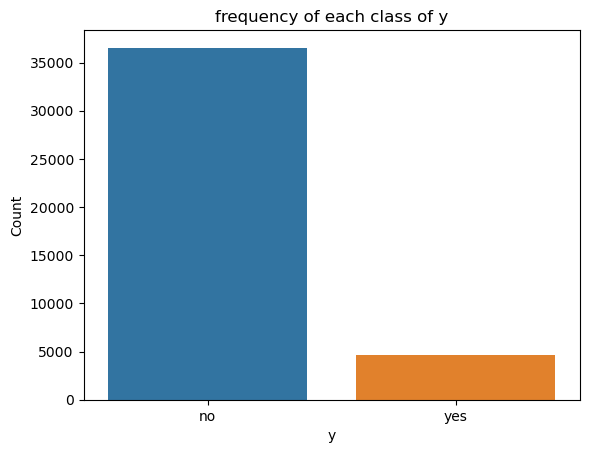

In [21]:
#bar plot of target column
sns.countplot(x='y', data=df)

# Added labels and title
plt.xlabel('y')
plt.ylabel('Count')
plt.title('frequency of each class of y')


plt.show()


**Business Objective**: 
The business problem entails creating a predictive model to determine if clients will subscribe to a term deposit during phone marketing campaigns ('yes' or 'no), aiming to optimize future marketing efficiency and enhance the success rate of subscription outcomes.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [22]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [23]:
df['y'] = df['y'].apply(lambda x: True if x == 'yes' else False) # Change object output to bool
df['default'] = df['default'].apply(lambda x: True if x == 'yes' else False) # Change object output to bool
df['housing'] = df['housing'].apply(lambda x: True if x == 'yes' else False) # Change object output to bool
df['loan'] = df['loan'].apply(lambda x: True if x == 'yes' else False) # Change object output to bool
df['previous_bool'] = df['previous'].apply(lambda x: True if x != 0 else False) # Change object output to bool for visualization and modeling purpuses
    
#dealing with outliers by capping them with 3 times std + mean.
#outliers = ['duration']
#upper_limit = df[outliers].mean() + 3*df[outliers].std() 
#for i in upper_limit.index:
 #   df[i] = df[i].apply(lambda x: upper_limit.loc[i] if x > upper_limit.loc[i] else x)
    
#drop columns:
to_drop =[ 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'day_of_week','duration']  #'pdays',
df.drop(columns= to_drop, inplace=True)


In [24]:
# Extracted relevant columns
bank_data = df.iloc[:, :7]

# Encoded categorical features
label_encoder = LabelEncoder()
#bank_data['age'] = df['age']
bank_data['job'] = label_encoder.fit_transform(bank_data['job'])
bank_data['marital'] = label_encoder.fit_transform(bank_data['marital'])
bank_data['education'] = label_encoder.fit_transform(bank_data['education'])
bank_data['default'] = label_encoder.fit_transform(bank_data['default'])
bank_data['housing'] = label_encoder.fit_transform(bank_data['housing'])
bank_data['loan'] = label_encoder.fit_transform(bank_data['loan'])

# Created a target column and encoding it
bank_data['y'] = label_encoder.fit_transform(df['y'])
# bank_data['y'] = df['y'].map({'yes': 1, 'no': 0})


In [25]:
bank_data

,age,job,marital,education,default,housing,loan,y
0,56,3,1,0,0,0,0,0
1,57,7,1,3,0,0,0,0
2,37,7,1,3,0,1,0,0
3,40,0,1,1,0,0,0,0
4,56,7,1,3,0,0,1,0
...,...,...,...,...,...,...,...,...
41183,73,5,1,5,0,1,0,1
41184,46,1,1,5,0,0,0,0
41185,56,5,1,6,0,1,0,0
41186,44,9,1,5,0,0,0,1


In [26]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41176 entries, 0 to 41187
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        41176 non-null  int64
 1   job        41176 non-null  int64
 2   marital    41176 non-null  int64
 3   education  41176 non-null  int64
 4   default    41176 non-null  int64
 5   housing    41176 non-null  int64
 6   loan       41176 non-null  int64
 7   y          41176 non-null  int64
dtypes: int64(8)
memory usage: 2.8 MB


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [27]:
# Split into features (X) and target (y)
X = bank_data.drop('y', axis=1)
y = bank_data['y']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [28]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Created a Dummy Classifier
dummy_classifier = DummyClassifier(strategy="most_frequent")

# Fit the Dummy Classifier on the training data
dummy_classifier.fit(X_train, y_train)

# Made predictions on the test set
dummy_pred = dummy_classifier.predict(X_test)

# Calculated accuracy
dummy_accuracy = accuracy_score(y_test, dummy_pred)

print(f"Dummy Classifier Accuracy: {dummy_accuracy:.2%}")


Dummy Classifier Accuracy: 88.41%


In [29]:
dummy_precision = precision_score(y_test, dummy_pred)
print(f"Dummy Classifier Precision: {dummy_precision:.2%}")

Dummy Classifier Precision: 0.00%


/Users/dopemantwizzy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score, recall_score, classification_report, confusion_matrix, f1_score


# Separated features (X) and target variable (y)
X = bank_data.drop('y', axis=1)  # Assuming 'y' is the target variable
y = bank_data['y']

# Converted categorical variables to dummy/indicator variables (one-hot encoding)
X = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Standardized the features (optional but often recommended for Logistic Regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Created and train the Logistic Regression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Made predictions on the test set
y_pred = model.predict(X_test)
#print(y_pred)
#print(y_train)

# Evaluated the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Printed the results
print(f"Accuracy: {accuracy:.4f}")
# print("Classification Report:")
# print(classification_rep)
# print(conf_matrix)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8841
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
Confusion Matrix:
[[5461    0]
 [ 716    0]]


/Users/dopemantwizzy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dopemantwizzy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dopemantwizzy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dopemantwizzy/anac

In [31]:
y_test.value_counts()

0    5461
1     716
Name: y, dtype: int64

In [32]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

### Problem 9: Score the Model

What is the accuracy of your model?

88.41%

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [33]:

# Initialized models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

# Created a DataFrame to store the results
results_list = []


# Looped through models
for model_name, model in models.items():
    start_time = time.time()
    
    # Trained the model
    model.fit(X_train, y_train)
    
    # Recorded training time
    train_time = time.time() - start_time
    
    # Predictions on training set
    train_pred = model.predict(X_train)
    
    # Predictions on test set
    test_pred = model.predict(X_test)
    
    # Recorded training and test accuracy
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)
    
    # Appended results to DataFrame
    results_list.append({
        'Model': model_name,
        'Train Time': train_time,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy
    })



results_df = pd.DataFrame(results_list, columns=['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy'])
# Display the results
results_df

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.326813,0.887911,0.884086
1,KNN,0.010901,0.889311,0.872592
2,Decision Tree,0.033274,0.909912,0.871459
3,SVM,15.485724,0.888111,0.883439


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Logistic Regression
logreg_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

logreg_grid = GridSearchCV(LogisticRegression(random_state=42), logreg_params, cv=5, scoring='accuracy')
logreg_grid.fit(X_train, y_train)


# Displayed the best parameters and corresponding score
print("Logistic Regression - Best Parameters:", logreg_grid.best_params_)
print("Logistic Regression - Best Accuracy:", logreg_grid.best_score_)




Logistic Regression - Best Parameters: {'C': 0.001, 'penalty': 'l2'}
Logistic Regression - Best Accuracy: 0.8879110852570775


/Users/dopemantwizzy/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/dopemantwizzy/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dopemantwizzy/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/dopemantwizzy/anaconda3/lib/python3.11/site-packages/

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score


# Separated features (X) and target variable (y)
X = df.drop(['y'], axis=1)  # Assuming 'y' is the target variable
y = label_encoder.fit_transform(df['y'])  #df['y']

# Converted categorical variables to dummy/indicator variables (one-hot encoding)
X = pd.get_dummies(X)

# Split the data into training and testing sets
X_traini, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardized the features (optional but often recommended for Logistic Regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_traini)
X_test = scaler.transform(X_test)

# Created and train the Logistic Regression model
model = LogisticRegression(random_state=42,C= 0.001, penalty= 'l2' )
model.fit(X_train, y_train)

# Made predictions on the test set
y_pred = model.predict(X_test)
#print(y_pred)
#print(y_train)

# Evaluated the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Printed the results
print(f"Accuracy: {accuracy:.4f}")
# print("Classification Report:")
# print(classification_rep)
# print(conf_matrix)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.8929
Precision: 0.7432
Recall: 0.1401
F1-Score: 0.2357
Confusion Matrix:
[[7218   47]
 [ 835  136]]


In [38]:
feature_names = X.columns  
coefficients = model.coef_[0]

# Created a DataFrame to store feature names and coefficients
feature_coefs = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sorted the DataFrame by absolute coefficient values for better visualization
feature_coefs['Absolute Coefficient'] = feature_coefs['Coefficient'].abs()
feature_coefs = feature_coefs.sort_values(by='Absolute Coefficient', ascending=False)

# Displayed the feature names and corresponding coefficients
print(feature_coefs[['Feature', 'Coefficient']])

                          Feature  Coefficient
5                           pdays    -0.354211
38                      month_mar     0.177233
31               contact_cellular     0.167278
32              contact_telephone    -0.167278
41                      month_oct     0.158515
4                        campaign    -0.130388
42                      month_sep     0.121262
33                      month_apr     0.115163
39                      month_may    -0.110908
12                    job_retired     0.102934
37                      month_jun     0.085050
35                      month_dec     0.081007
15                    job_student     0.080921
34                      month_aug    -0.073438
40                      month_nov    -0.068880
8                 job_blue-collar    -0.058170
21                 marital_single     0.053263
36                      month_jul    -0.048896
6                   previous_bool     0.048828
29    education_university.degree     0.046589
25           

In [39]:
feature_coefs10 = feature_coefs.head(10)

/var/folders/s_/v1gz0yqs2z9bbg18b7h118880000gn/T/ipykernel_2453/1545456753.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_coefs10.sort_values(by='Absolute Coefficient', ascending=False, inplace=True)


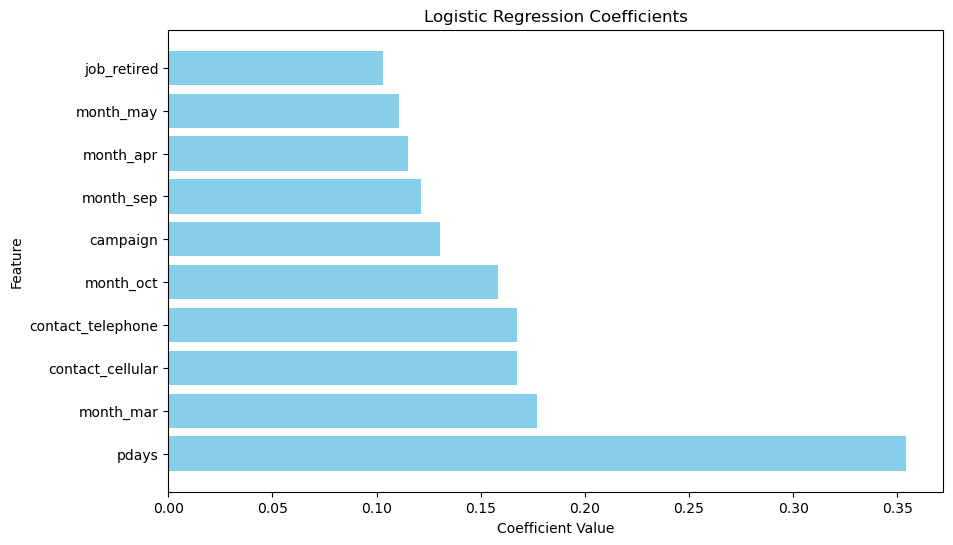

In [40]:
import matplotlib.pyplot as plt

# Assuming 'feature' is the column containing feature names, and 'coef' is the column containing coefficients
feature_coefs10.sort_values(by='Absolute Coefficient', ascending=False, inplace=True)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(feature_coefs10['Feature'], feature_coefs10['Absolute Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients')
plt.show()

##### Considering the imbalanced distribution of our target variable, we have chosen to employ both SMOTE and ADASYN techniques to improve the performance of our model.

In [42]:
# SVM
#svm_params = {
#    'C': [0.001, 0.01, 0.1, 1, 10, 100],
#    'kernel': ['linear', 'rbf', 'poly'],
#    'gamma': ['scale', 'auto']
#}
#
#svm_grid = GridSearchCV(SVC(random_state=42), svm_params, cv=5, scoring='accuracy')
#svm_grid.fit(X_train, y_train)
#
# Displayed the best parameters and corresponding score
#print("SVM - Best Parameters:", svm_grid.best_params_)
#print("SVM - Best Accuracy:", svm_grid.best_score_)

In [41]:
# Logistic Regression
logreg_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}


# Decision Tree Parameters
params_dt = {
    "max_depth": [5, 10, 15, 20, 25, 30, None], # Maximum depth of the decision tree
    "criterion": ["gini","entropy"], # The quality criterion to measure the information gain when splitting nodes
    "min_samples_split": [2,3], # Minimum number of samples required to split an internal node
    "min_samples_leaf": [1,2] # Minimum number of samples required to be at a leaf node
}


# KNN Parameters
params_knn = {
    "n_neighbors": range(20, 151, 10), # Number of neighbors to consider for each data point
    "weights": ["uniform","distance"] # The weight function used in prediction (uniform weights or weights based on inverse distance)
}

In [42]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)
print(f"""
Original X shape: {X_train.shape}
SMOTE X shape: {X_smote.shape}
""")


Original X shape: (58459, 43)
SMOTE X shape: (73074, 43)



In [43]:
from sklearn.model_selection import RandomizedSearchCV

# Initialized models
models = {
    'Logistic Regression': GridSearchCV(LogisticRegression(random_state=42), logreg_params, cv=5, scoring=["recall", "accuracy", 'precision'], refit="recall"),
    'KNN': GridSearchCV( KNeighborsClassifier(), params_knn,n_jobs=-1, cv=10, scoring=["recall", "accuracy", 'precision'], refit="recall"),
    'Decision Tree': RandomizedSearchCV(DecisionTreeClassifier(random_state=42),params_dt,n_jobs=-1,cv=10,n_iter= 10,scoring=["recall", "accuracy", 'precision'], refit="recall"),
    # 'SVM': SVC(random_state=42)
}

# Created a DataFrame to store the results
results_list = []
model_coefs = []
# Looped through models
for model_name, model in models.items():
    start_time = time.time()
    
    # Trained the model
    model.fit(X_train, y_train)
    
    # Recorded training time
    train_time = time.time() - start_time
    
    # Predictions on training set
    train_pred = model.predict(X_train)
    
    # Predictions on test set
    test_pred = model.predict(X_test)
    
    # Recorded training and test accuracy
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)
    train_precision = precision_score(y_train, train_pred)
    test_precision = precision_score(y_test, test_pred)
    train_recall = recall_score(y_train, train_pred)
    test_recall = recall_score(y_test, test_pred)
    
    # Appended results to DataFrame
    results_list.append({
        'Model': model_name,
        'Train Time': train_time,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Train Precision': train_precision,
        'Test Precision': test_precision,
        'Train Recall': train_recall,
        'Test Recall': test_recall,
    })



results_df = pd.DataFrame(results_list, columns=['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy', 'Train Precision', 'Test Precision', 'Train Recall', 'Test Recall'])
# Display the results
results_df

/Users/dopemantwizzy/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dopemantwizzy/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

,Model,Train Time,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall
0,Logistic Regression,17.961345,0.846268,0.844338,0.894013,0.891714,0.786163,0.781891
1,KNN,892.597199,0.983014,0.843996,0.985142,0.780831,0.980868,0.954039
2,Decision Tree,3.226452,0.976787,0.890455,0.977096,0.878946,0.976529,0.904225


In [45]:
conf_matrix = confusion_matrix(y_test, test_pred)
conf_matrix

array([[6443,  905],
       [ 696, 6571]])

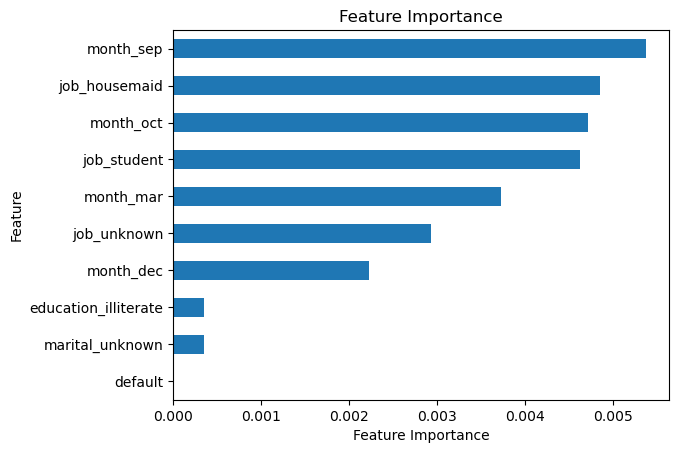

In [49]:
# Get feature names from training data
features = X_train.columns

# Extract importances from model
importances = models['Decision Tree'].best_estimator_.feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances, index=features)
# Plot 10 most important features
feat_imp.sort_values().head(10).plot(kind="barh")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

##### Questions

although accuracy is high, the model is biased towards predicting that a client will NOT subscribe. and this was detected by looking at the precision and the recall score. Precision and recall does not tell the full story of the performance of the model, therefore the f1 score is being used as the eveluation metric. 

future consideration :  perform a smote or a resampling 

last month of contact is an impotant feature for determining wether a client will subscribe or not 